In [1]:
import osmnx
from leuvenmapmatching.matcher.distance import DistanceMatcher
from leuvenmapmatching.map.inmem import InMemMap
import osmread
from dataclasses import dataclass
from geopandas.geodataframe import GeoDataFrame
import json
from dataclasses import dataclass
import pandas as pd
import numpy as np
import folium
from typing import Iterable
import networkx as nx
from datetime import datetime, timedelta
import numba
from scipy.interpolate import interp1d
from typing import Iterable
import networkx as nx
from datetime import datetime, timedelta
import matplotlib as mpl
from folium.features import DivIcon
from helper_utils import MatchedRoutes,Segments

f = open('../matched-results-1500.json')
data = json.load(f)


# graph = osmnx.graph_from_place('Porto, Portugal', network_type='drive', simplify=False)
# graph = osmnx.load_graphml('./porto.graphml')
graph = osmnx.graph_from_place('Porto, Portugal', network_type='drive', simplify=False,which_result=2)
graph_proj = osmnx.project_graph(graph)
nodes_proj, edges_proj = osmnx.graph_to_gdfs(graph_proj, nodes=True, edges=True)


map_con = InMemMap("myosm", use_latlon=True, use_rtree=True, index_edges=True)
for nid, row in nodes_proj[['lat', 'lon']].iterrows():
    map_con.add_node(nid, (row['lat'], row['lon']))
for eid, _ in edges_proj.iterrows():
    map_con.add_edge(eid[0], eid[1])
    
matcher = DistanceMatcher(map_con,
                         max_dist=1000, max_dist_init=25,  # meter
                         min_prob_norm=0.001,
                         non_emitting_length_factor=0.75,
                         obs_noise=50, obs_noise_ne=75,  # meter
                         dist_noise=50,  # meter
                         non_emitting_states=True,
                         max_lattice_width=5)

df = pd.DataFrame(data)
df = df[df['MATCHED_RESULTS'].apply(lambda x: len(x['Matched_edge_for_each_point'])>5)]

In [2]:
# from simpledbf import Dbf5
# dbf2 = Dbf5('./nodes.dbf')
# df2 = dbf2.to_dataframe()
# df2[['lon','lat']] = df2[['x','y']].copy()
# df2.index = df2['osmid']
# df2

In [3]:
routes = df.apply(lambda x: MatchedRoutes.from_df(x,nodes_proj),axis=1)
# sum([r.matched_geo.shape[0]==0 for r in routes])
routes = [r for r in routes if r.matched_geo.shape[0]>0]

# Get most travelled segments
1. Get all segment pairs
2. Filter only traversed trajectories
3. Form DF with source-target and timedelta
2. Do a groupby and count the segment pairs

In [4]:
import numba
from scipy.interpolate import interp1d
@numba.njit
def get_cleaned_idx(nodes:Iterable[int]):
    idx = np.empty(0)
    cleaned = np.empty(0)
    for i in range(len(nodes)):
        n = nodes[i]
        if (n not in cleaned) or (len(cleaned)==0):
            cleaned = np.append(cleaned,n)
            idx = np.append(idx,i)
            
    return cleaned.astype(np.int64),idx.astype(np.int64)


segment_df = pd.DataFrame()
for r in routes:
    nodes_s = r.osmid_source
    nodes_t = r.osmid_target
    times = r.gps_time
    geo_matches = r.matched_geo
    geo_time = np.array([datetime.timestamp(x) for x in r.matched_geo_time])

    cleaned_nodes,idx = get_cleaned_idx(nodes_s)
    cleaned_times = times[idx]
    seg_start = cleaned_nodes[:-1]
    seg_end = cleaned_nodes[1:]
    
    time_delta = cleaned_times[1:]-cleaned_times[:-1]
    
    t_interps = [np.linspace(datetime.timestamp(a),datetime.timestamp(b),100) for a,b in zip(cleaned_times[:-1],cleaned_times[1:])]

    if geo_time.shape[0]>1:
        # print(geo_time.shape,geo_matches.shape)
        interp = interp1d(geo_time[:-1],geo_matches,axis=0,bounds_error=0)
        segment_gps = [interp(t) for t in t_interps]
    else:
        segment_gps = [None for _ in range(time_delta.shape[0])]
    
    df_ = pd.DataFrame({'source':seg_start,'target':seg_end,'time_taken':[x.seconds for x in time_delta],'coordinates':segment_gps})
    segment_df = pd.concat([segment_df,df_])

In [7]:
grouped_df = segment_df.groupby(['source','target'],as_index=False).agg({"time_taken": [np.mean, 'count']})
grouped_df = grouped_df.sort_values(('time_taken','count'))
top10_segments = grouped_df.iloc[-10:].copy()


# top10_segments[]

grouped_df = grouped_df.sort_values(('time_taken','mean'))
top10_time = grouped_df[grouped_df[('time_taken','count')]>5].iloc[-10:].copy()

top10_segments


C:\Users\Chan Li Long\AppData\Local\Temp\ipykernel_17136\1355273151.py:1: FutureWarning: The provided callable <function mean at 0x00000226C357C160> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grouped_df = segment_df.groupby(['source','target'],as_index=False).agg({"time_taken": [np.mean, 'count']})


source      target time_taken      
                                    mean count
2410    279916540   279907160  15.000000    84
685     112263308   111642668  21.428571    84
2445    280240272  1725592653  15.000000    85
2393    279907004   280240272  15.176471    85
9901   3092747274    26015879  22.747253    91
660     111642668  1725590806  25.894737    95
1466    128579264  2490198505  18.315789    95
11072  4722746602   112263308  41.515152    99
2397    279907160   279915425  16.440000   125
2399    279915425    90376961  34.392857   140

In [8]:
top10_time

source      target  time_taken      
                                     mean count
3581    353289223   353289224   90.000000     6
10244  3584513100   503018158   90.000000     7
5474    497690595   126582697   90.000000     7
7096   1235787118  8007969950   92.142857     7
109      25632226    25632228  105.000000     6
1566    128655660   417058220  125.454545    11
10112  3392939433  3992990334  130.714286    14
8219   1594598177  1771990365  137.500000     6
8610   1771990365   112688608  141.428571     7
1942    137896681  2208891134  141.666667     9

# Top 10 Most Traversed Road Segments

In [9]:
import seaborn as sns
pal = sns.color_palette('pastel').as_hex()
S,T = top10_segments[['source','target']].values.T

porto_coords = nodes_proj[['lat','lon']].mean().values
m = folium.Map(location=porto_coords , zoom_start=15)

folium.TileLayer('cartodbpositron').add_to(m)

for i,(s,t,c) in enumerate(zip(reversed(S),reversed(T),pal)):
    # c = mpl.colors.rgb2hex(np.random.rand(3,), keep_alpha=True)
    # try:
    sfilter = (segment_df['source']==s) & (segment_df['target']==t)
    coord = nodes_proj.loc[[s,t]][['lat','lon']].values
    # coord = df2.loc[[int(s),int(t)]][['lat','lon']].values
    # df2
    map_con.purge()
    states, lastidx = matcher.match(coord)
    match = Segments.from_state(states,nodes_proj)
    coords = match.df[['lat','lon']].values

    folium.PolyLine(coords,
                color=c,
                weight=15,
                opacity=1).add_to(m)


    folium.CircleMarker(location=coords[:1],
                           radius=10,    
                           color=c,
                           fill_color =c,
                           fill_opacity=0.7,
                          ).add_to(m)
    folium.map.Marker(coords[:1],
                      icon=DivIcon(
                          icon_size=(30,30),
                          icon_anchor=(5,14),
                          html=f'<div style="font-size: 14pt">%s</div>' % str(i+1),
                      )
                     ).add_to(m)
    
m

# Top 10 Road Segments with Long Duration

In [10]:
S,T = top10_time[['source','target']].values.T


m = folium.Map(location=porto_coords, zoom_start=15)
pal = sns.color_palette('pastel').as_hex()
folium.TileLayer('cartodbpositron').add_to(m)

for i,(s,t,c) in enumerate(zip(reversed(S),reversed(T),pal)):
    # c = mpl.colors.rgb2hex(np.random.uniform(low=0.,high=0.7,size=(3,)), keep_alpha=True)
    
    sfilter = (segment_df['source']==s) & (segment_df['target']==t)
    coord = nodes_proj.loc[[s,t]][['lat','lon']].values
    map_con.purge()
    states, lastidx = matcher.match(coord)
    match = Segments.from_state(states,nodes_proj)
    coords = match.df[['lat','lon']].values
    
    folium.PolyLine(coords,
                color=c,
                weight=15,
                opacity=1).add_to(m)
        
        
    folium.CircleMarker(location=coords[:1],
                           radius=10,    
                           color=c,
                           fill_color =c,
                           fill_opacity=0.7,
                          ).add_to(m)
    folium.map.Marker(coords[:1],
                      icon=DivIcon(
                          icon_size=(30,30),
                          icon_anchor=(5,14),
                          html=f'<div style="font-size: 14pt">%s</div>' % str(i+1),
                      )
                     ).add_to(m)
    


m

# Miscalaneous EDA: Get most travelled routes
1. Get similarity measure distance matrix based on Frechet Dist
2. Cluster based on distance matrix (N X M) (200-300 clusters)
3. Sort clusters by counts
4. visualize most travelled routes

In [13]:
from numba import njit, prange
from tqdm.notebook import tqdm
from similarity_numba import frechet_dist,dtw

def latlon_to_xyz(arr):
    """Convert angluar to cartesian coordiantes

    latitude is the 90deg - zenith angle in range [-90;90]
    lonitude is the azimuthal angle in range [-180;180] 
    """
    lon,lat = arr.T
    r = 6371 # https://en.wikipedia.org/wiki/Earth_radius
    theta = np.pi/2 - np.radians(lat) 
    phi = np.radians(lon)
    x = r * np.sin(theta) * np.cos(phi) # bronstein (3.381a)
    y = r * np.sin(theta) * np.sin(phi)
    # z = r * np.cos(theta)
    
    # return [x,y,z]
    return np.concatenate([x.reshape(-1,1),y.reshape(-1,1)],axis=1)


@numba.njit(fastmath=True,parallel=True)
def compute_distance_matrix(trajectories,length_mask):
    """
    :param method: "Frechet" or "Area"
    """
    n = trajectories.shape[0]
    dist_m = np.zeros((n, n))
    for i in np.arange(n - 1):
        p = trajectories[i,:length_mask[i]]
        for j in prange(i + 1, n):
            q = trajectories[j,:length_mask[j]]
            # dist_m[i, j] = area_between_two_curves(p, q)
            dist_m[i, j] = dtw(p, q)[0] + 10000*(np.mean((p[0]-q[0])**2) + np.mean((p[-1]-q[-1])**2))
            # dist_m[i, j] = pcm(p, q)
            dist_m[j, i] = dist_m[i, j]
    return dist_m

geos_ = [r.matched_geo for r in routes if r.matched_geo.shape[0]>1]
geos = [latlon_to_xyz(r.matched_geo) for r in routes if r.matched_geo.shape[0]>1]
lengths = np.array([x.shape[0] for x in geos])
geos_arr = np.zeros((len(geos),max(lengths),2))
for i,(g,l) in enumerate(zip(geos_,lengths)):
    geos_arr[i,:l] = g
compute_distance_matrix(geos_arr[:5],lengths[:5])

array([[  0.        ,  20.75421218,  13.57150611,  27.25352443,
         45.76669377],
       [ 20.75421218,   0.        ,  48.06095979,  72.26584079,
          9.39945791],
       [ 13.57150611,  48.06095979,   0.        ,  31.79019106,
         89.1668224 ],
       [ 27.25352443,  72.26584079,  31.79019106,   0.        ,
        107.14380811],
       [ 45.76669377,   9.39945791,  89.1668224 , 107.14380811,
          0.        ]])

In [14]:
dist_mat = compute_distance_matrix(geos_arr,lengths)

In [25]:
from sklearn.cluster import DBSCAN,SpectralClustering
from sklearn.cluster import AgglomerativeClustering


cl = AgglomerativeClustering(affinity='precomputed', n_clusters=500, linkage='complete')
cl.fit(dist_mat)
classes = cl.labels_

df_traj = pd.DataFrame({'traj':geos_,'lengths':lengths,'classes':classes})

C:\Anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


C:\Anaconda3\envs\ML\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Anaconda3\envs\ML\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Anaconda3\envs\ML\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


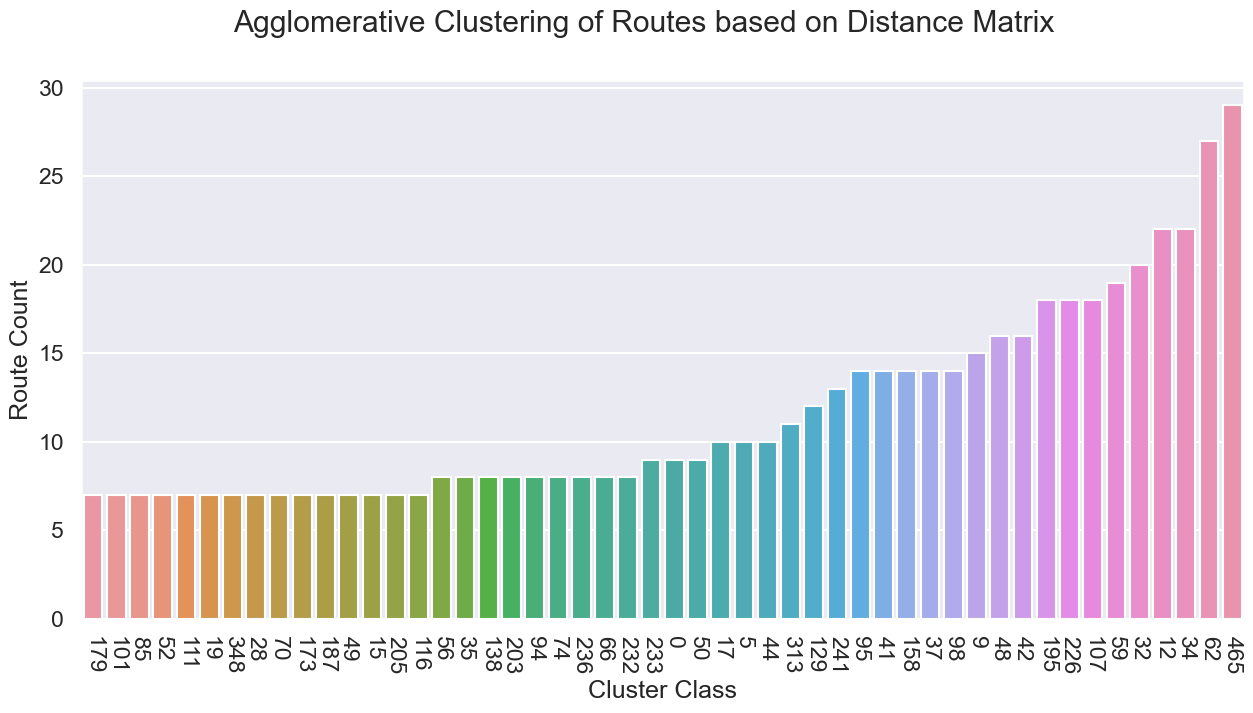

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_context('talk')
counts = df_traj.groupby('classes')['traj'].count().sort_values()#[:-1]

fig,ax = plt.subplots(1,1,figsize=(15,7))
sns.barplot(y=counts[-50:],x=counts.index.astype(str)[-50:])
plt.xticks(rotation=-90)
plt.xlabel('Cluster Class')
plt.ylabel('Route Count')
plt.suptitle('Agglomerative Clustering of Routes based on Distance Matrix')
plt.show()

In [28]:
m = folium.Map(location=porto_coords, zoom_start=15)
folium.TileLayer('cartodbpositron').add_to(m)
pal = sns.color_palette('pastel').as_hex()

def plot_start_end(m,start,end,color,idx):
    folium.CircleMarker(location=start,
                       radius=10,    
                       color=color,
                       fill_color =color,
                       fill_opacity=1,
                      ).add_to(m)
    folium.map.Marker(start,
                      icon=DivIcon(
                          icon_size=(30,30),
                          icon_anchor=(5,14),
                          html=f'<div style="font-size: 14pt">%s</div>' % f'S{idx}',
                      )
                     ).add_to(m)
    
    folium.CircleMarker(location=end,
                   radius=10,    
                   color=color,
                   fill_color =color,
                   fill_opacity=1,
                  ).add_to(m)
    folium.map.Marker(end,
                      icon=DivIcon(
                          icon_size=(30,30),
                          icon_anchor=(5,14),
                          html=f'<div style="font-size: 14pt">%s</div>' % 'E',
                      )
                     ).add_to(m)

for i in range(5):
    # c = mpl.colors.rgb2hex(np.random.rand(3,), keep_alpha=True)
    c = pal[i%len(pal)]
    df_ = df_traj[df_traj['classes']==counts.index[-(i+1)]]#.sample(50)
    
    start = np.asarray([x[0] for x in df_['traj']]).mean(0)
    end = np.asarray([x[-1] for x in df_['traj']]).mean(0)
    
    folium.PolyLine(df_['traj'].values,
                    color=c,
                    weight=15,
                    opacity=0.9).add_to(m)
    
    plot_start_end(m,start,end,c,i+1)
m

In [23]:
1%15

1